# Rain events


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.lines import Line2D
import json

from fault_management_uds.data.load import import_external_metadata, import_metadata
from fault_management_uds.data.hdf_tools import print_tree, load_dataframe_from_HDF5
from fault_management_uds.plots import visualize_indicator_dict
from fault_management_uds.modelling.classifiers import classify_rain_events



from fault_management_uds.config import PROJ_ROOT
from fault_management_uds.config import DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR, EXTERNAL_DATA_DIR
from fault_management_uds.config import MODELS_DIR, REPORTS_DIR, FIGURES_DIR, REFERENCE_DIR
from fault_management_uds.config import rain_gauges


2024-12-22 14:53:19.655 | INFO     | fault_management_uds.config:<module>:15 - PROJ_ROOT path is: /work3/s194262/GitHub/fault_management_uds
2024-12-22 14:53:20.806522: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-22 14:53:21.151162: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734875601.195079  788379 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734875601.208178  788379 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
20

### Load rain data

In [2]:
data_file_path = PROCESSED_DATA_DIR / 'Bellinge.h5'
f = print_tree(data_file_path)

root
├── combined_data
│   ├── clean
│   │   ├── columns
│   │   ├── data
│   │   └── timestamps
│   └── raw
│       ├── columns
│       ├── data
│       └── timestamps
└── single_series
    ├── rain_gauge_data
    │   ├── 5425
    │   │   ├── columns
    │   │   ├── data
    │   │   └── timestamps
    │   └── 5427
    │       ├── columns
    │       ├── data
    │       └── timestamps
    └── sewer_data
        ├── G71F04R_Level1
        │   ├── bools
        │   │   ├── columns
        │   │   ├── data
        │   │   └── timestamps
        │   ├── clean
        │   │   ├── columns
        │   │   ├── data
        │   │   └── timestamps
        │   └── raw
        │       ├── columns
        │       ├── data
        │       └── timestamps
        ├── G71F04R_Level2
        │   ├── bools
        │   │   ├── columns
        │   │   ├── data
        │   │   └── timestamps
        │   ├── clean
        │   │   ├── columns
        │   │   ├── data
        │   │   └── timestamps
        │ 

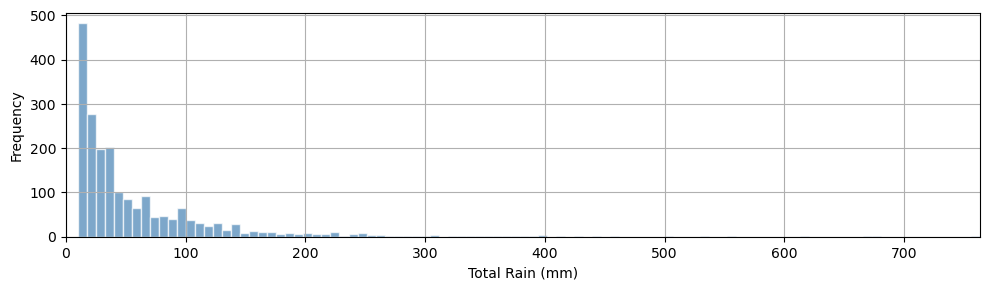

In [ ]:
# # visualize histrogram for duration
# fig, ax = plt.subplots(figsize=(10, 3), dpi=100)
# rain_events.total_rain.hist(bins=100, ax=ax, color='#4682b4', alpha=0.7, edgecolor='white')
# ax.set_xlim(0, max(rain_events.total_rain))
# #ax.set_title('Total Rain (mm) Distribution')
# ax.set_xlabel('Total Rain (mm)')
# ax.set_ylabel('Frequency')
# plt.tight_layout()
# plt.savefig(save_folder / 'total_rain_distribution.png', dpi=100)
# plt.show()
# plt.close()

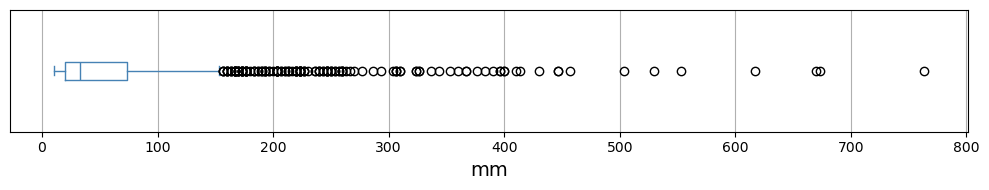

In [ ]:
# # visualize histrogram for duration
# fig, ax = plt.subplots(figsize=(10, 2), dpi=100)
# # boxplot
# rain_events.boxplot(column='total_rain', ax=ax, vert=False, color='#4682b4')
# #ax.set_title('Total Rain (mm) for Each Event')
# ax.set_xlabel('mm', fontsize=14)
# # remove y-axis
# ax.set_yticks([])
# plt.tight_layout()
# plt.savefig(save_folder / 'total_rain_boxplot.png', dpi=100)
# plt.show()
# plt.close()


# Classify rain events

- use the function
- 3 criteria
    - min mm of total rainfall
    - min duration
    - max gap between rain events

In [ ]:
save_folder = REFERENCE_DIR / 'events'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

In [9]:
metadata = import_metadata(REFERENCE_DIR / 'sensor_metadata.csv')
starttime = metadata['StartTime'].min()
endtime = metadata['EndTime'].max()

In [5]:
# load clean and bools for the whole dataset and create the indicator
rain_data, _, _, _ = load_dataframe_from_HDF5(data_file_path, 'combined_data/clean', 
    starttime=starttime, endtime=endtime, columns=rain_gauges, 
    complete_range=True
    )


In [ ]:
# get the rain series, unit is mm/minute
rain_events = {}
for rain_gague in rain_gauges:
    rain_gauge_data = rain_data[[rain_gague]].copy()
    rain_gauge_data.rename(columns={rain_gague: 'value'}, inplace=True)
    rain_events[rain_gague] = classify_rain_events(rain_gauge_data, min_event_rainfall=5)
    # convert datetime to string
    rain_events[rain_gague]['start'] = rain_events[rain_gague]['start'].dt.strftime('%Y-%m-%d %H:%M:%S')
    rain_events[rain_gague]['end'] = rain_events[rain_gague]['end'].dt.strftime('%Y-%m-%d %H:%M:%S')
    # convert df to dict
    rain_events[rain_gague] = rain_events[rain_gague].to_dict(orient='records')

Classifying rain events: 100%|██████████| 6117121/6117121 [02:38<00:00, 38633.24it/s]


In [4]:
# save the rain events
rain_events_file_path = REFERENCE_DIR / 'events' / 'rain_gauge_rain_events.json'

In [25]:
with open(rain_events_file_path, 'w') as f:
    json.dump(rain_events, f, indent=4)

Load

In [5]:
# load the rain events
with open(rain_events_file_path, 'r') as f:
    rain_events = json.load(f)

for rain_gague in rain_gauges:
    rain_events[rain_gague] = pd.DataFrame(rain_events[rain_gague])
    rain_events[rain_gague]['start'] = pd.to_datetime(rain_events[rain_gague]['start'])
    rain_events[rain_gague]['end'] = pd.to_datetime(rain_events[rain_gague]['end'])


In [13]:
n_rain = rain_events['5425']['duration'].sum()

In [14]:
n_data = pd.date_range(starttime, endtime, freq='1min').shape[0]

In [16]:
(n_rain / n_data) * 100 # unit is percentage

6.0646993904485464

In [23]:
# Calculate the number of dynamic and non-dynamic samples
num_dynamic = n_rain
num_non_dynamic = n_data - n_rain

# Set non-dynamic weights to 1
non_dynamic_weight = 1

# Calculate dynamic weight
desired_dynamic_proportion = 0.20
dynamic_weight = (desired_dynamic_proportion * num_non_dynamic) / ((1 - desired_dynamic_proportion) * num_dynamic)
dynamic_weight # weight to be _% of the dataset

3.872215857784007

#### Combine rain events to create a dry and wet conditions dataset



In [29]:
# Function to merge overlapping intervals
def merge_intervals(df):

    # Sort the DataFrame by start time
    df = df.sort_values(by='start').reset_index(drop=True)

    merged_intervals = []
    current_start = df.loc[0, 'start']
    current_end = df.loc[0, 'end']
    current_rainfall = df.loc[0, 'rainfall']

    for i in range(1, len(df)):
        row_start = df.loc[i, 'start']
        row_end = df.loc[i, 'end']
        row_rainfall = df.loc[i, 'rainfall']

        if row_start <= current_end:  # Overlapping intervals
            current_end = max(current_end, row_end)
            # add the rainfall
            current_rainfall += row_rainfall
        else:
            # No overlap, add the current interval to the list
            merged_intervals.append({'start': current_start, 'end': current_end, 'rainfall': current_rainfall})
            # Start a new interval
            current_start = row_start
            current_end = row_end
            current_rainfall = row_rainfall

    # Append the last interval
    merged_intervals.append({'start': current_start, 'end': current_end, 'rainfall': current_rainfall})

    return pd.DataFrame(merged_intervals)

In [30]:
# filter to only have the start and end of the rain events
rain_events = {rain_gague: rain_events[rain_gague][['start', 'end', 'rainfall']] for rain_gague in rain_gauges}

# concatenate the rain gauges
rain_events = pd.concat(rain_events.values(), axis=0)

# # add the response time + reset time for the system for 4 hours
# rain_events['end'] = rain_events['end'] + pd.Timedelta(hours=2)

In [31]:
# merge overlapping intervals
rain_events = merge_intervals(rain_events)

In [32]:
rain_events.shape, wet_conditions.shape

((2998, 3), (2998, 3))

In [68]:
rain_events['duration'] = (rain_events['end'] - rain_events['start']).dt.total_seconds() / 60

In [ ]:
# save
rain_events.to_csv(save_folder / 'rain_events.csv', index=False)

Load

In [ ]:
rain_events = pd.read_csv(save_folder / 'rain_events.csv')
rain_events['start'] = pd.to_datetime(rain_events['start'])
rain_events['end'] = pd.to_datetime(rain_events['end'])

# Extreme events

- based on being outliers within a boxplot, i.e. outside the whiskers (1.5 * IQR)


In [5]:
# classify extreme rain events based on:
# - duration
# - rainfall
# - intensity

# based on being outliers within a boxplot, i.e. outside the whiskers (1.5 * IQR)

In [6]:
rain_events['intensity'] = rain_events['rainfall'] / rain_events['duration']
rain_events['extreme'] = False

In [7]:
variables = ['duration', 'rainfall']#, 'intensity']

for variable in variables:
    # calculate the IQR
    Q1 = rain_events[variable].quantile(0.25)
    Q3 = rain_events[variable].quantile(0.75)
    IQR = Q3 - Q1
    # calculate the whiskers
    upper_bound = Q3 + 1.5 * IQR
    # classify as extreme
    extreme = rain_events[variable] > upper_bound
    rain_events.loc[extreme, 'extreme'] = True

In [ ]:
# re-save
rain_events.to_csv(save_folder / 'rain_events.csv', index=False)

Load

In [ ]:
rain_events = pd.read_csv(save_folder / 'rain_events.csv')
rain_events['start'] = pd.to_datetime(rain_events['start'])
rain_events['end'] = pd.to_datetime(rain_events['end'])

# Classify dry conditions

- based on periods after 24 hours of no rain

In [37]:
# combine both rain gauges
rainfall = rain_data.sum(axis=1).to_frame(name='rainfall')

In [ ]:
# identify the dry conditions 

# Calculate the rolling sum of rainfall over _ hours
no_rain_for = 1440 // 2 # 12 hours
rolling_no_rain = rainfall['rainfall'].rolling(window=no_rain_for, min_periods=1).sum()

# Identify periods where there has been no rain for 24 hours
no_rain_periods = rolling_no_rain == 0

# Identify the start and end of each dry period
dry_conditions = []
current_start = None
for i, no_rain in enumerate(no_rain_periods):
    # true
    if no_rain:
        # if there is no current start, set the current time as the start
        if current_start is None:
            current_start = rainfall.index[i]
    # false
    else:
        # if there is a current start, save the period
        if current_start is not None:
            dry_conditions.append({'start': current_start, 'end': rainfall.index[i-1]})
            current_start = None

# if there is a current start, save the period
if current_start is not None:
    dry_conditions.append({'start': current_start, 'end': rainfall.index[i]})
    current_start = None

# convert to dataframe
dry_conditions = pd.DataFrame(dry_conditions)

# set end 1 hour back
dry_conditions['end'] = dry_conditions['end'] - pd.Timedelta(hours=1)
# remove events less than 1 hour
dry_conditions = dry_conditions.loc[(dry_conditions['end'] - dry_conditions['start']) >= pd.Timedelta(hours=1)]


In [ ]:
# save
dry_conditions.to_csv(save_folder / 'dry_conditions.csv', index=False)

In [ ]:
# load
dry_conditions = pd.read_csv(save_folder / 'dry_conditions.csv') 
dry_conditions['start'] = pd.to_datetime(dry_conditions['start'])
dry_conditions['end'] = pd.to_datetime(dry_conditions['end'])

In [59]:
dry_conditions.shape, rain_events.shape

((1412, 2), (2998, 3))

In [ ]:
dry_conditions['duration'].mean(), rain_events['duration'].mean()

(2968.537535410765, 138.87691794529687)

In [216]:
# sum of duration in days
dry_conditions['duration'].sum() / 60 / 24, rain_events['duration'].sum() / 60 / 24

(2910.815972222222, 289.13402777777776)

# Analysis

In [82]:
save_folder = FIGURES_DIR / 'analysis' / 'rain_events'
os.makedirs(save_folder, exist_ok=True)

In [ ]:
# load rain events and dry conditions
rain_events = pd.read_csv(REFERENCE_DIR / 'events' / 'rain_events.csv')
rain_events['start'] = pd.to_datetime(rain_events['start'])
rain_events['end'] = pd.to_datetime(rain_events['end'])

dry_conditions = pd.read_csv(REFERENCE_DIR / 'events' / 'dry_conditions.csv')
dry_conditions['start'] = pd.to_datetime(dry_conditions['start'])
dry_conditions['end'] = pd.to_datetime(dry_conditions['end'])

In [78]:
starttime, endtime = metadata['StartTime'].min(), metadata['EndTime'].max()

### Timeline

In [185]:
# get timestamps
timestamps = pd.date_range(starttime, endtime, freq='1min')
# count minutes from starttime to endtime
n_obs = len(timestamps)
rain_events_indicator = np.zeros(n_obs)
extreme_events_indicator = np.zeros(n_obs)
dry_conditions_indicator = np.zeros(n_obs)

# rain events
for i, row in rain_events.iterrows():
    start = timestamps.get_loc(row['start'])
    end = timestamps.get_loc(row['end'])
    rain_events_indicator[start:end] = 1
    # set to 3 if extreme
    if row['extreme']:
        extreme_events_indicator[start:end] = 1

# dry conditions
for i, row in dry_conditions.iterrows():
    start = timestamps.get_loc(row['start'])
    end = timestamps.get_loc(row['end'])
    dry_conditions_indicator[start:end] = 1


In [188]:
indicator_dict = {
    'Rain Events': {
        'indicator': rain_events_indicator,
        'colormap': {
            0: 'floralwhite',
            1: 'lightskyblue',
        },
    },
    'Extreme Events': {
        'indicator': extreme_events_indicator,
        'colormap': {
            0: 'floralwhite',
            1: 'violet',
        },
    },
    'Dry Conditions': {
        'indicator': dry_conditions_indicator,
        'colormap': {
            0: 'floralwhite',
            1: 'bisque',
        },
    },
}

legend_handles = []
for key in indicator_dict:
    legend_handles.append(Line2D([0], [0], color=indicator_dict[key]['colormap'][1], lw=4, label=key))


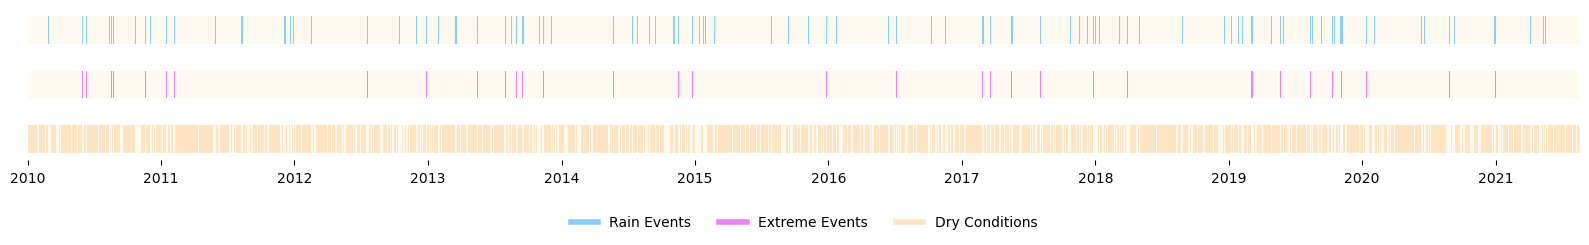

In [189]:
fig, ax = plt.subplots(figsize=(16, 3))
ax = visualize_indicator_dict(ax, indicator_dict, start=starttime, end=endtime, adjust='half-point', ylabel=f'Total Rain Events: {rain_events.shape[0]}')

ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False); ax.spines['left'].set_visible(False); ax.spines['bottom'].set_visible(False);
ax.set_title('')
ax.set_yticks([])

# legend
ax.legend(handles=legend_handles, loc='lower center', ncol=len(legend_handles), frameon=False, bbox_to_anchor=(0.5, -0.55))

plt.tight_layout()

# save
fig.savefig(save_folder / 'timeline_events.png', dpi=500, bbox_inches='tight')
plt.show()
plt.close()

### Count of events and conditions

- count, average durations, sum

In [ ]:
# create a combined table
# - count, 

In [290]:
extreme_events = rain_events[rain_events['extreme']]

In [344]:
table = {}
for key, event in zip(indicator_dict.keys(), [rain_events, extreme_events, dry_conditions]):
    table[key] = {
        'Total events': event.shape[0],
        #'Total days': round(np.sum(indicator_dict[key]['indicator']) / 60 / 24),
        'Average duration': round(event['duration'].mean()),
    }

# no index
table = pd.DataFrame(table).T
#table = table.reset_index(drop=False, names='Event type')
table

,Total events,Average duration
Rain Events,2998,139
Extreme Events,501,314
Dry Conditions,1412,2969


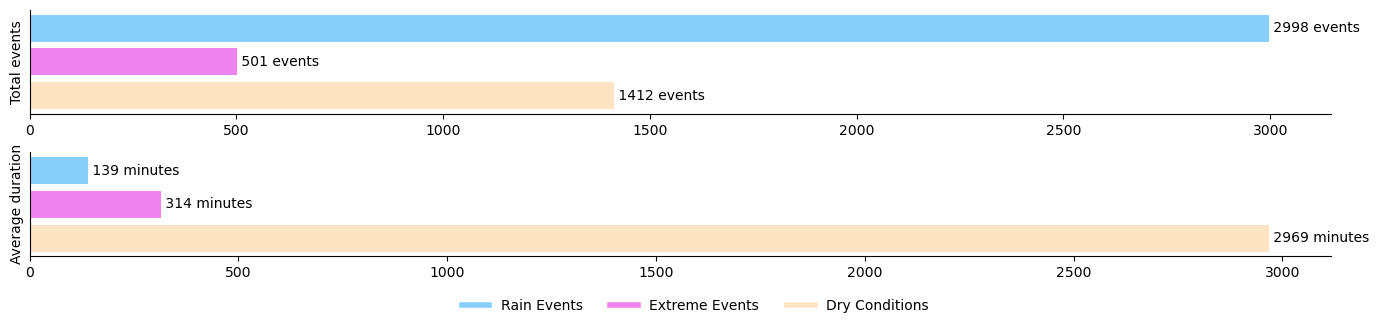

In [350]:
fig, axs = plt.subplots(table.shape[1], 1, figsize=(14, 3))

# visualize each column in each subplot, color by the event type
event_colors = [indicator_dict[event_type]['colormap'][1] for event_type in table.index]
for i, col in enumerate(table.columns):
    metric_name = col.split(' ')[-1].lower()
    metric_name = 'minutes' if metric_name == 'duration' else metric_name
    col_val = table[col]
    axs[i].barh(col_val.index, col_val.values, color=event_colors)
    axs[i].set_yticks([])
    
    #axs[i].set_title(f"\n{col}", fontsize=14)
    axs[i].set_ylabel(f"{col}")#, fontsize=14)
    # add end text  
    for j, val in enumerate(col_val):
        axs[i].text(val, j, f' {val} {metric_name}', color='black', va='center')
    axs[i].invert_yaxis()
    # remove spines
    axs[i].spines['top'].set_visible(False); axs[i].spines['right'].set_visible(False)

# add legend
legend_handles = []
for key in indicator_dict:
    legend_handles.append(Line2D([0], [0], color=indicator_dict[key]['colormap'][1], lw=4, label=key))
fig.legend(handles=legend_handles, loc='lower center', ncol=len(legend_handles), frameon=False, bbox_to_anchor=(0.5, -0.1))
plt.tight_layout()
plt.show()
# save
fig.savefig(save_folder / 'event_counts.png', dpi=120, bbox_inches='tight')
plt.close()

### Time based bar plots

In [293]:
def plot_counts(ax, df, column, order=None, kind='bar', color='#9291f3'):

    # Count the occurrences of each category in the specified column
    counts = df[column].value_counts()#.reindex(order)
    
    # if order specified, then reindex
    if order is not None:
        counts = counts.reindex(order)
        # fill na with 0
        counts = counts.fillna(0)
    else:
        # order by key name
        counts = counts.sort_index()

    # Plot the bar chart
    counts.plot(kind=kind, ax=ax, color=color)

    # Add counts on top of each bar
    for i, count in enumerate(counts):
        formatted_count = f"{int(count):,}".replace(',', ' ')
        if kind == 'bar':
            ax.text(i, count, formatted_count, ha='center', va='bottom')
            # rotate x labels
            ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
        else:
            ax.text(count, i, formatted_count, ha='left', va='center')
            # invert y-axis
            ax.invert_yaxis()

    # remove y-axis label
    ax.set_ylabel('')
    ax.set_xlabel('')
    return ax

In [294]:
rain_events['year'] = rain_events['start'].dt.year
rain_events['month'] = rain_events['start'].dt.month
rain_events['hour'] = rain_events['start'].dt.hour

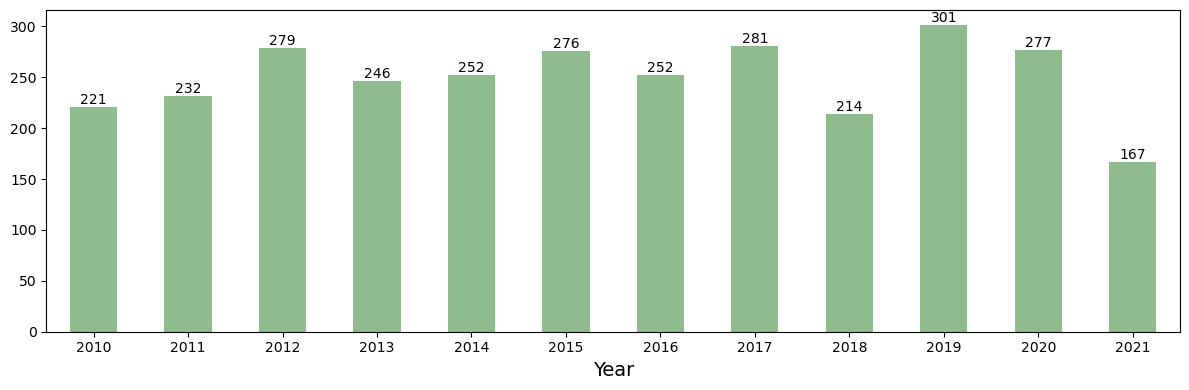

In [295]:
# year
fig, ax = plt.subplots(figsize=(12, 4), dpi=100)
ax = plot_counts(ax, rain_events, 'year', kind='bar', color='darkseagreen')
ax.set_xlabel('Year', fontsize=14)
plt.tight_layout()
plt.show()

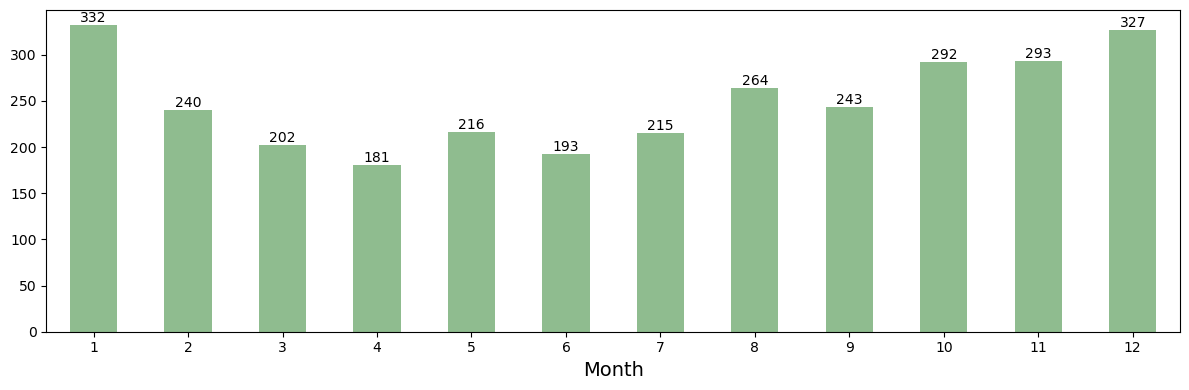

In [296]:
# month
fig, ax = plt.subplots(figsize=(12, 4), dpi=100)
ax = plot_counts(ax, rain_events, 'month', kind='bar', color='darkseagreen')
ax.set_xlabel('Month', fontsize=14)
plt.tight_layout()
# save
fig.savefig(save_folder / 'rain_events_month.png', dpi=120)
plt.show()
plt.close()

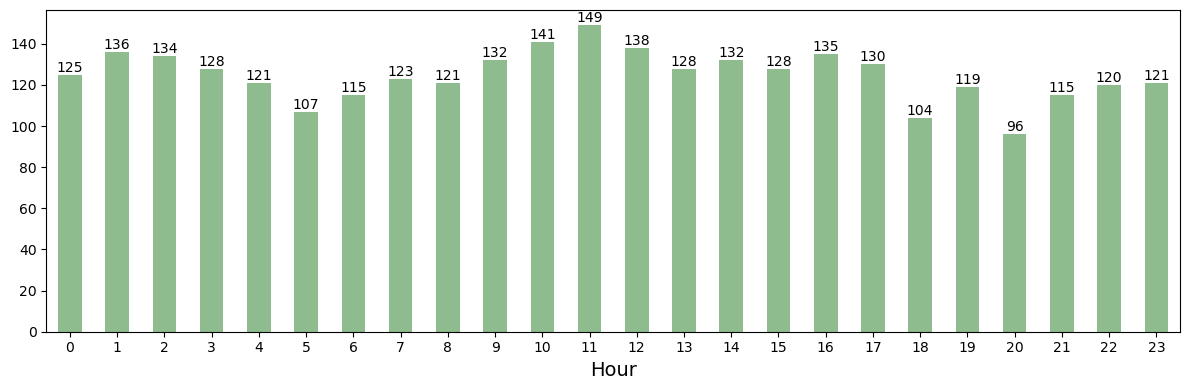

In [297]:
# hour
fig, ax = plt.subplots(figsize=(12, 4), dpi=100)
ax = plot_counts(ax, rain_events, 'hour', kind='bar', color='darkseagreen')
ax.set_xlabel('Hour', fontsize=14)
plt.tight_layout()
plt.show()

### Distributions

- 2 cols for rain gauges, 3 for each variable

In [300]:
save_folder = FIGURES_DIR / 'analysis' / 'rain_events' / 'distrubution'
os.makedirs(save_folder, exist_ok=True)

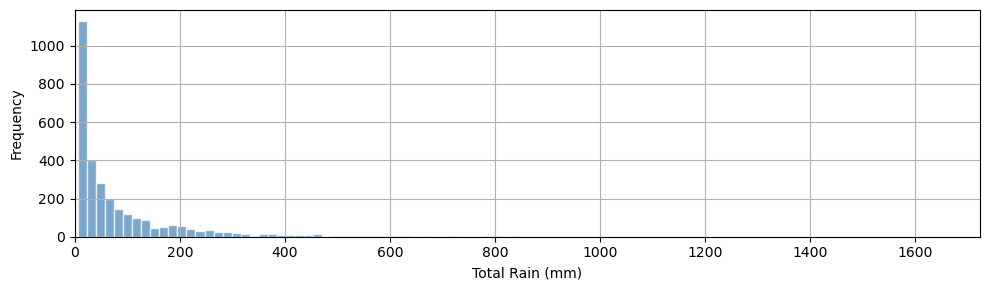

In [301]:
# visualize histrogram for duration
fig, ax = plt.subplots(figsize=(10, 3), dpi=100)
rain_events.rainfall.hist(bins=100, ax=ax, color='#4682b4', alpha=0.7, edgecolor='white')
ax.set_xlim(0, max(rain_events.rainfall))
#ax.set_title('Total Rain (mm) Distribution')
ax.set_xlabel('Total Rain (mm)')
ax.set_ylabel('Frequency')
plt.tight_layout()
plt.savefig(save_folder / 'total_rain_distribution.png', dpi=100)
plt.show()
plt.close()

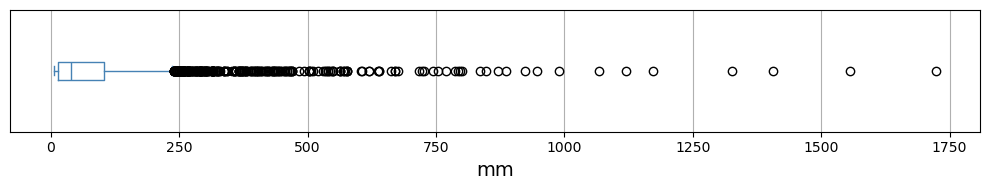

In [303]:
# visualize histrogram for duration
fig, ax = plt.subplots(figsize=(10, 2), dpi=100)
# boxplot
rain_events.boxplot(column='rainfall', ax=ax, vert=False, color='#4682b4')
#ax.set_title('Total Rain (mm) for Each Event')
ax.set_xlabel('mm', fontsize=14)
# remove y-axis
ax.set_yticks([])
plt.tight_layout()
plt.savefig(save_folder / 'total_rain_boxplot.png', dpi=100)
plt.show()
plt.close()


Duration

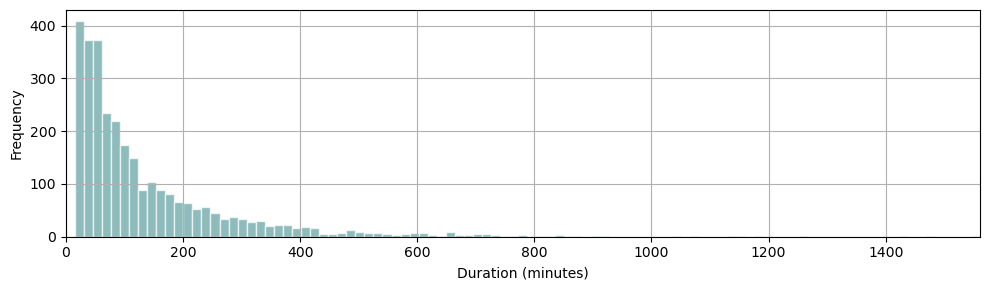

In [304]:
# visualize histrogram for duration
fig, ax = plt.subplots(figsize=(10, 3), dpi=100)
rain_events.duration.hist(bins=100, ax=ax, color='#5f9ea0', alpha=0.7, edgecolor='white')
ax.set_xlim(0, max(rain_events.duration))
#ax.set_title('Total Rain (mm) Distribution')
ax.set_xlabel('Duration (minutes)')
ax.set_ylabel('Frequency')
plt.tight_layout()
plt.savefig(save_folder / 'duration_hist.png', dpi=100)
plt.show()
plt.close()

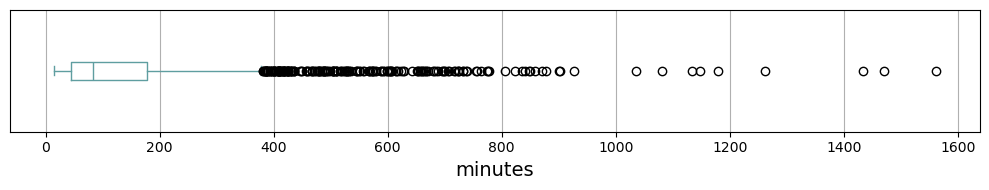

In [305]:
# visualize histrogram for duration
fig, ax = plt.subplots(figsize=(10, 2), dpi=100)
# boxplot
rain_events.boxplot(column='duration', ax=ax, vert=False, color='#5f9ea0')
#ax.set_title('Total Rain (mm) for Each Event')
ax.set_xlabel('minutes', fontsize=14)
# remove y-axis
ax.set_yticks([])
plt.tight_layout()
plt.savefig(save_folder / 'duration_boxplot.png', dpi=100)
plt.show()
plt.close()

Intensity

In [307]:
rain_events['intensity'] = rain_events['rainfall'] / rain_events['duration']

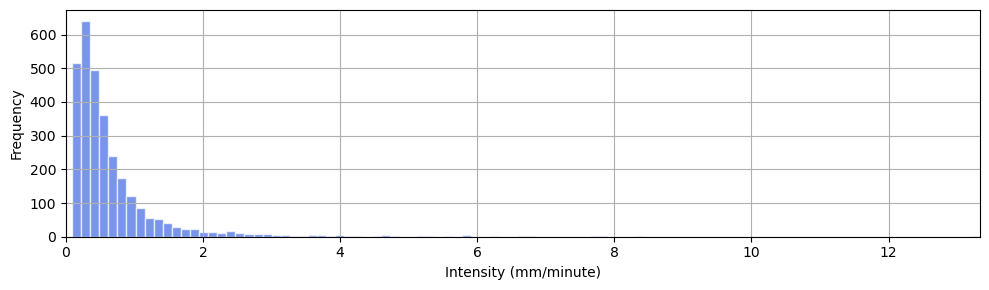

In [308]:
# visualize histrogram for duration
fig, ax = plt.subplots(figsize=(10, 3), dpi=100)
rain_events.intensity.hist(bins=100, ax=ax, color='#4169e1', alpha=0.7, edgecolor='white')
ax.set_xlim(0, max(rain_events.intensity))
#ax.set_title('Total Rain (mm) Distribution')
ax.set_xlabel('Intensity (mm/minute)')
ax.set_ylabel('Frequency')
plt.tight_layout()
plt.savefig(save_folder / 'intensity_hist.png', dpi=100)
plt.show()
plt.close()

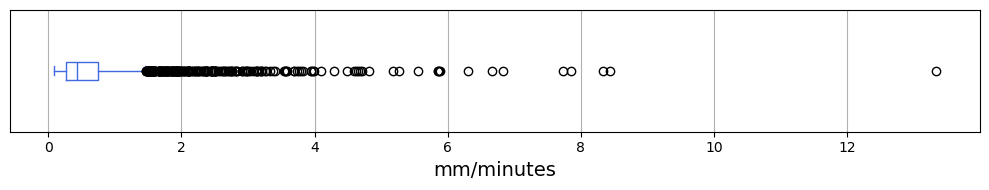

In [309]:
# visualize histrogram for duration
fig, ax = plt.subplots(figsize=(10, 2), dpi=100)
# boxplot
rain_events.boxplot(column='intensity', ax=ax, vert=False, color='#4169e1')
#ax.set_title('Total Rain (mm) for Each Event')
ax.set_xlabel('mm/minutes', fontsize=14)
# remove y-axis
ax.set_yticks([])
plt.tight_layout()
plt.savefig(save_folder / 'intensity_boxplot.png', dpi=100)
plt.show()
plt.close()

### Scatter with extreme events

In [351]:
save_folder = FIGURES_DIR / 'analysis' / 'rain_events'


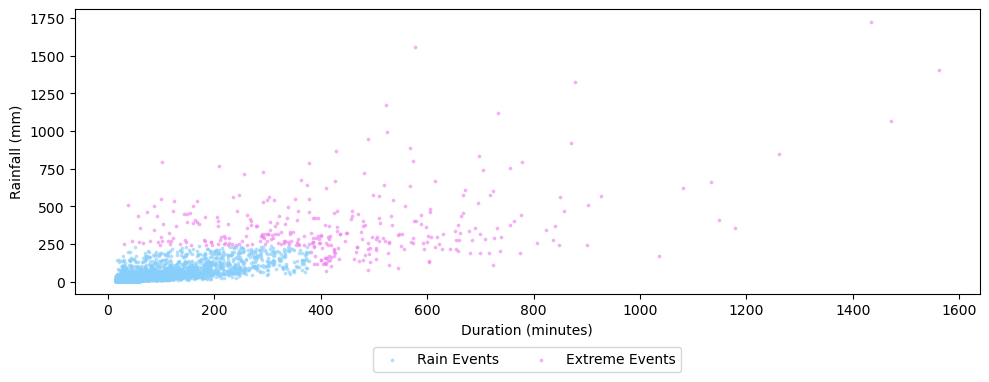

In [352]:
# scattter, total rain as a function of duration
fig, ax = plt.subplots(figsize=(10, 4))
not_extreme = rain_events[rain_events.extreme == False]
extreme = rain_events[rain_events.extreme == True]
ax.scatter(not_extreme.duration, not_extreme.rainfall, color='lightskyblue', alpha=0.5, s=3)
ax.scatter(extreme.duration, extreme.rainfall, color='violet', alpha=0.5, s=3)
# # set limits to x and y
# ax.set_xlim(0, max(rain_events.duration) + 50)
# ax.set_ylim(0, max(rain_events.rainfall) + 50)
# legend
ax.legend(['Rain Events', 'Extreme Events'], loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=2)
ax.set_xlabel('Duration (minutes)')
ax.set_ylabel('Rainfall (mm)')
#ax.set_title('Total Rain vs Duration')
plt.tight_layout()
plt.show()
# save
fig.savefig(save_folder / 'total_rain_vs_duration.png', dpi=100)
plt.close()
del not_extreme, extreme